In [21]:
import sys
sys.path.append("..")

import time
import pandas as pd
import matplotlib.pyplot as plt

from datasets.custom_dataset import CustomDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale, ToPILImage, ToTensor, Normalize, CenterCrop, RandomAdjustSharpness

from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassAUROC

from sklearn.model_selection import train_test_split

# Carga del set de datos

## Directorios

In [22]:
dataset_path = '../datasets/covid-19-radiography-dataset.csv'
unfiltered_images_path = '../datasets/unfiltered_images'
bilateral_filtered_images_path = '../datasets/bilateral_filtered_images'

dataset = pd.read_csv(dataset_path)
dataset_file_names = dataset['file_name']
dataset_labels = dataset['label']

dataset.head()

,file_name,label
0,COVID-1.png,0
1,COVID-10.png,0
2,COVID-100.png,0
3,COVID-1000.png,0
4,COVID-1001.png,0


## Distribución de las clases en el set de datos

In [23]:
class_ids = {
    0: 'covid',
    1: 'lung_opacity',
    2: 'normal',
    3: 'viral_pneumonia'
}

def count_dataset_classes(labels, class_ids):
    class_count = {
        'covid': 0,
        'lung_opacity': 0,
        'normal': 0,
        'viral_pneumonia': 0
    }
    
    for label in labels:
        class_id = class_ids[label]
        class_count[class_id] += 1
    
    return class_count

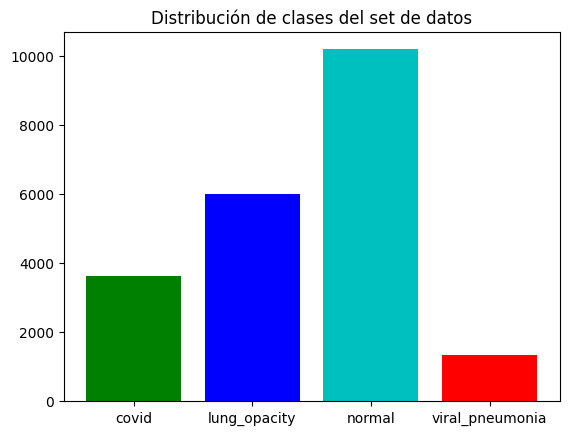

In [24]:
dataset_class_count = count_dataset_classes(dataset_labels, class_ids)

fig, ax = plt.subplots()
ax.set_title('Distribución de clases del set de datos')
ax.bar(list(dataset_class_count.keys()), list(dataset_class_count.values()), color=['g', 'b', 'c', 'r'])

plt.show()

## División del set de datos

Train set distribution:  {'covid': 2893, 'lung_opacity': 4809, 'normal': 8154, 'viral_pneumonia': 1076}
Test set distribution:  {'covid': 723, 'lung_opacity': 1203, 'normal': 2038, 'viral_pneumonia': 269}
Test vs Train distribution:  {'covid': 0.19994469026548672, 'lung_opacity': 0.2000998003992016, 'normal': 0.1999607535321821, 'viral_pneumonia': 0.2}


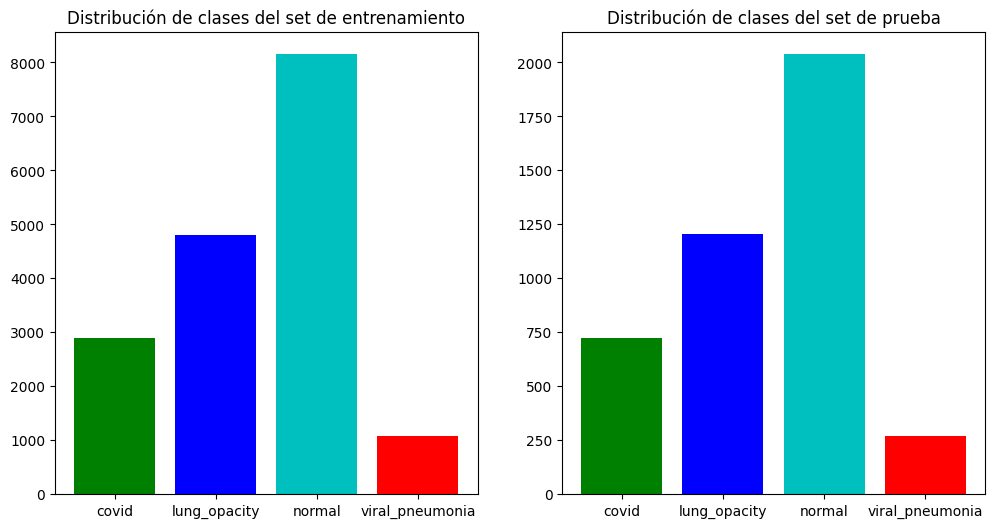

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_file_names, dataset_labels, test_size=0.2, random_state=404, stratify=dataset_labels)

train_class_count = count_dataset_classes(y_train, class_ids)
test_class_count = count_dataset_classes(y_test, class_ids)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Distribución de clases del set de entrenamiento')
ax[0].bar(list(train_class_count.keys()), list(train_class_count.values()), color=['g', 'b', 'c', 'r'])

ax[1].set_title('Distribución de clases del set de prueba')
ax[1].bar(list(test_class_count.keys()), list(test_class_count.values()), color=['g', 'b', 'c', 'r'])

print('Train set distribution: ', train_class_count)
print('Test set distribution: ', test_class_count)
print('Test vs Train distribution: ', {k: test_class_count[k] / (dataset_class_count[k]) for k in test_class_count})
plt.show()

## Uso de GPU si está disponible

In [26]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


# Métricas de evaluación

## Definición de métricas

In [27]:
train_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)
test_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)

train_precision = MulticlassPrecision(num_classes=4, average=None).to(device)
test_precision = MulticlassPrecision(num_classes=4, average=None).to(device)

train_recall = MulticlassRecall(num_classes=4, average=None).to(device)
test_recall = MulticlassRecall(num_classes=4, average=None).to(device)

train_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)
test_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)

train_roc = MulticlassROC(num_classes=4).to(device)
test_roc = MulticlassROC(num_classes=4).to(device)

train_auroc = MulticlassAUROC(num_classes=4).to(device)
test_auroc = MulticlassAUROC(num_classes=4).to(device)

## Cálculo de métricas

In [28]:
def compute_metrics(train_list, test_list, train_loss, test_loss):
    train_list.append({'loss': train_loss,
                       'accuracy': train_accuracy.compute(),
                       'precision': train_precision.compute(), 
                       'recall': train_recall.compute(),
                       'f1': train_f1.compute(),
                       'roc': train_roc.compute(),
                       'auroc': train_auroc.compute()})
    
    test_list.append({'loss': test_loss,
                      'accuracy': test_accuracy.compute(),
                      'precision': test_precision.compute(),
                      'recall': test_recall.compute(),
                      'f1': test_f1.compute(),
                      'roc': test_roc.compute(),
                      'auroc': test_auroc.compute()})
    
    train_accuracy.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    train_roc.reset()
    train_auroc.reset()
    
    test_accuracy.reset()
    test_precision.reset()
    test_recall.reset()
    test_f1.reset()
    test_roc.reset()
    test_auroc.reset()

## Tablas de las métricas

In [29]:
def show_accuracy_table(train_accuracies, test_accuracies, epochs):
    accuracy_df = pd.DataFrame({
        'Covid Train Accuracy': [train_accuracies[i][0].item() for i in range(epochs)],
        'Covid Test Accuracy': [test_accuracies[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity Accuracy': [train_accuracies[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity Accuracy': [test_accuracies[i][1].item() for i in range(epochs)],
        
        'Normal Train Accuracy': [train_accuracies[i][2].item() for i in range(epochs)],
        'Normal Test Accuracy': [test_accuracies[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Accuracy': [train_accuracies[i][3].item() for i in range(epochs)],
        'Pneumonia Test Accuracy': [test_accuracies[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    accuracy_df.index.name = 'Epoch'
    display(accuracy_df)

In [30]:
def show_precision_table(train_precisions, test_precisions, epochs):
    precision_df = pd.DataFrame({
        'Covid Train Precision': [train_precisions[i][0].item() for i in range(epochs)],
        'Covid Test Precision': [test_precisions[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity Precision': [train_precisions[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity Precision': [test_precisions[i][1].item() for i in range(epochs)],
        
        'Normal Train Precision': [train_precisions[i][2].item() for i in range(epochs)],
        'Normal Test Precision': [test_precisions[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Precision': [train_precisions[i][3].item() for i in range(epochs)],
        'Pneumonia Test Precision': [test_precisions[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    precision_df.index.name = 'Epoch'
    display(precision_df)

In [31]:
def show_recall_table(train_recalls, test_recalls, epochs):
    recall_df = pd.DataFrame({
        'Covid Train Recall': [train_recalls[i][0].item() for i in range(epochs)],
        'Covid Test Recall': [test_recalls[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity Recall': [train_recalls[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity Recall': [test_recalls[i][1].item() for i in range(epochs)],
        
        'Normal Train Recall': [train_recalls[i][2].item() for i in range(epochs)],
        'Normal Test Recall': [test_recalls[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Recall': [train_recalls[i][3].item() for i in range(epochs)],
        'Pneumonia Test Recall': [test_recalls[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    recall_df.index.name = 'Epoch'
    display(recall_df)

In [32]:
def show_f1_score_table(train_f1_scores, test_f1_scores, epochs):
    f1_score_df = pd.DataFrame({
        'Covid Train F1-Score': [train_f1_scores[i][0].item() for i in range(epochs)],
        'Covid Test F1-Score': [test_f1_scores[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Opacity F1-Score': [train_f1_scores[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Opacity F1-Score': [test_f1_scores[i][1].item() for i in range(epochs)],
        
        'Normal Train F1-Score': [train_f1_scores[i][2].item() for i in range(epochs)],
        'Normal Test F1-Score': [test_f1_scores[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train F1-Score': [train_f1_scores[i][3].item() for i in range(epochs)],
        'Pneumonia Test F1-Score': [test_f1_scores[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])
    
    f1_score_df.index.name = 'Epoch'
    display(f1_score_df) 

In [33]:
def show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0, 0].set_title('ROC Curve for Covid')
    ax[0, 0].set_ylabel('TPR')
    ax[0, 0].set_xlabel('FPR')

    ax[0, 1].set_title('ROC Curve for Lung Opacity')
    ax[0, 1].set_ylabel('TPR')
    ax[0, 1].set_xlabel('FPR')

    ax[1, 0].set_title('ROC Curve for Normal')
    ax[1, 0].set_ylabel('TPR')
    ax[1, 0].set_xlabel('FPR')

    ax[1, 1].set_title('ROC Curve for Pneumonia')
    ax[1, 1].set_ylabel('TPR')
    ax[1, 1].set_xlabel('FPR')

    ax[0, 0].plot(train_roc_fpr[0], train_roc_tpr[0], label='Train', color='b')
    ax[0, 0].plot(test_roc_fpr[0], test_roc_tpr[0], label='Test', color='g')

    ax[0, 1].plot(train_roc_fpr[1], train_roc_tpr[1], label='Train', color='b')
    ax[0, 1].plot(test_roc_fpr[1], test_roc_tpr[1], label='Test', color='g')

    ax[1, 0].plot(train_roc_fpr[2], train_roc_tpr[2], label='Train', color='b')
    ax[1, 0].plot(test_roc_fpr[2], test_roc_tpr[2], label='Test', color='g')

    ax[1, 1].plot(train_roc_fpr[3], train_roc_tpr[3], label='Train', color='b')
    ax[1, 1].plot(test_roc_fpr[3], test_roc_tpr[3], label='Test', color='g')

    ax[0, 0].legend()
    ax[0, 1].legend()
    ax[1, 0].legend()
    ax[1, 1].legend()
    fig.show()

In [34]:
def show_learning_curve(train_losses, test_losses, epoch_list):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Loss vs Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(epoch_list)

    ax.plot(epoch_list, train_losses, label='Train', color='b', marker='o')
    ax.plot(epoch_list, test_losses, label='Test', color='g', marker='o')

    ax.legend()
    fig.show()

# Función de entrenamiento

In [35]:
def train(dataloader, model, loss_fn, optimizer):
    print('--------------------------- Training --------------------------\n')
    size = len(dataloader.dataset)
    loss = torch.Tensor([0]).to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        
        train_accuracy.update(pred, y)
        train_precision.update(pred, y)
        train_recall.update(pred, y)
        train_f1.update(pred, y)    
        train_roc.update(pred, y)
        train_auroc.update(pred, y)
        
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'Current Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    
    return loss.item()

# Función de evaluación

In [36]:
def test(dataloader, model, loss_fn):
    print('--------------------------- Testing ---------------------------\n')
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            test_accuracy.update(pred, y)
            test_precision.update(pred, y)
            test_recall.update(pred, y)
            test_f1.update(pred, y)    
            test_roc.update(pred, y)
            test_auroc.update(pred, y)
            
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    accuracy_df = pd.DataFrame({
        'Covid Test Accuracy': [test_accuracy.compute()[0].item()],
        'Lung-Opacity Test Opacity Accuracy': [test_accuracy.compute()[1].item()],
        'Normal Test Accuracy': [test_accuracy.compute()[2].item()],
        'Pneumonia Test Accuracy': [test_accuracy.compute()[3].item()]
    })
    display(accuracy_df)
    return test_loss

# Red Convolucional 
## Sin Bilateral Filter

## Arquitectura del modelo

In [37]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=61504, out_features=4),
            nn.ReLU(),
            
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            # nn.ReLU(),
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            # nn.ReLU(),
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.ReLU(),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            # nn.ReLU(),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            # nn.ReLU(),
            
            # nn.Flatten(),
            # nn.Dropout(p=0.3),
            
            # nn.Linear(in_features=1600, out_features=4096),
            # nn.ReLU(),
            
            # nn.Linear(in_features=4096, out_features=40),
            # nn.ReLU(),
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

## Feature Engineering

In [38]:
unfiltered_train_dataset = CustomDataset(unfiltered_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

unfiltered_test_dataset = CustomDataset(unfiltered_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

## Entrenamiento del modelo

In [39]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 10

unfiltered_cnn_model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_cnn_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [40]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_cnn_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_cnn_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.404078  [   32/16932]
Current Loss: 1.383064  [  352/16932]
Current Loss: 1.365170  [  672/16932]
Current Loss: 1.382589  [  992/16932]
Current Loss: 1.409354  [ 1312/16932]
Current Loss: 1.391147  [ 1632/16932]
Current Loss: 1.407684  [ 1952/16932]
Current Loss: 1.400550  [ 2272/16932]
Current Loss: 1.381813  [ 2592/16932]
Current Loss: 1.378729  [ 2912/16932]
Current Loss: 1.388367  [ 3232/16932]
Current Loss: 1.362609  [ 3552/16932]
Current Loss: 1.391284  [ 3872/16932]
Current Loss: 1.364741  [ 4192/16932]
Current Loss: 1.378368  [ 4512/16932]
Current Loss: 1.358200  [ 4832/16932]
Current Loss: 1.355452  [ 5152/16932]
Current Loss: 1.381594  [ 5472/16932]
Current Loss: 1.365790  [ 5792/16932]
Current Loss: 1.342710  [ 6112/16932]
Current Loss: 1.371514  [ 6432/16932]
Current Loss: 1.324730  [ 6752/16932]
Current Loss: 1.315260  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.0,1.0,0.0


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.195576  [   32/16932]
Current Loss: 1.136253  [  352/16932]
Current Loss: 1.242478  [  672/16932]
Current Loss: 1.276907  [  992/16932]
Current Loss: 1.224772  [ 1312/16932]
Current Loss: 1.219403  [ 1632/16932]
Current Loss: 1.192994  [ 1952/16932]
Current Loss: 0.965840  [ 2272/16932]
Current Loss: 1.226287  [ 2592/16932]
Current Loss: 1.120615  [ 2912/16932]
Current Loss: 1.230381  [ 3232/16932]
Current Loss: 1.014271  [ 3552/16932]
Current Loss: 1.241674  [ 3872/16932]
Current Loss: 1.004698  [ 4192/16932]
Current Loss: 1.196760  [ 4512/16932]
Current Loss: 1.041605  [ 4832/16932]
Current Loss: 1.195487  [ 5152/16932]
Current Loss: 1.122994  [ 5472/16932]
Current Loss: 1.287711  [ 5792/16932]
Current Loss: 1.122857  [ 6112/16932]
Current Loss: 1.212563  [ 6432/16932]
Current Loss: 1.101017  [ 6752/16932]
Current Loss: 1.244507  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.007481,0.998528,0.0


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.243169  [   32/16932]
Current Loss: 1.108769  [  352/16932]
Current Loss: 1.208153  [  672/16932]
Current Loss: 1.008350  [  992/16932]
Current Loss: 0.970639  [ 1312/16932]
Current Loss: 0.902771  [ 1632/16932]
Current Loss: 1.176943  [ 1952/16932]
Current Loss: 1.054770  [ 2272/16932]
Current Loss: 1.190349  [ 2592/16932]
Current Loss: 1.087803  [ 2912/16932]
Current Loss: 1.182407  [ 3232/16932]
Current Loss: 1.200236  [ 3552/16932]
Current Loss: 1.335653  [ 3872/16932]
Current Loss: 1.164221  [ 4192/16932]
Current Loss: 1.210118  [ 4512/16932]
Current Loss: 1.013448  [ 4832/16932]
Current Loss: 1.125793  [ 5152/16932]
Current Loss: 1.153367  [ 5472/16932]
Current Loss: 1.044665  [ 5792/16932]
Current Loss: 1.097398  [ 6112/16932]
Current Loss: 1.225225  [ 6432/16932]
Current Loss: 1.062319  [ 6752/16932]
Current Loss: 1.038642  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.07315,0.994112,0.0


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.283728  [   32/16932]
Current Loss: 1.111452  [  352/16932]
Current Loss: 1.030329  [  672/16932]
Current Loss: 1.082794  [  992/16932]
Current Loss: 1.166264  [ 1312/16932]
Current Loss: 1.004810  [ 1632/16932]
Current Loss: 1.003988  [ 1952/16932]
Current Loss: 1.144015  [ 2272/16932]
Current Loss: 1.280977  [ 2592/16932]
Current Loss: 1.115486  [ 2912/16932]
Current Loss: 1.195789  [ 3232/16932]
Current Loss: 1.024443  [ 3552/16932]
Current Loss: 1.059204  [ 3872/16932]
Current Loss: 1.050066  [ 4192/16932]
Current Loss: 1.193759  [ 4512/16932]
Current Loss: 1.075542  [ 4832/16932]
Current Loss: 1.124374  [ 5152/16932]
Current Loss: 1.138629  [ 5472/16932]
Current Loss: 1.186513  [ 5792/16932]
Current Loss: 1.020432  [ 6112/16932]
Current Loss: 1.236799  [ 6432/16932]
Current Loss: 0.971245  [ 6752/16932]
Current Loss: 1.140998  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.248545,0.98528,0.0


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.949195  [   32/16932]
Current Loss: 1.019621  [  352/16932]
Current Loss: 1.002737  [  672/16932]
Current Loss: 1.289748  [  992/16932]
Current Loss: 0.977946  [ 1312/16932]
Current Loss: 0.999247  [ 1632/16932]
Current Loss: 1.253712  [ 1952/16932]
Current Loss: 1.287954  [ 2272/16932]
Current Loss: 1.031748  [ 2592/16932]
Current Loss: 0.995985  [ 2912/16932]
Current Loss: 1.000156  [ 3232/16932]
Current Loss: 0.971017  [ 3552/16932]
Current Loss: 1.081076  [ 3872/16932]
Current Loss: 1.309254  [ 4192/16932]
Current Loss: 1.184000  [ 4512/16932]
Current Loss: 1.058205  [ 4832/16932]
Current Loss: 1.152360  [ 5152/16932]
Current Loss: 1.112032  [ 5472/16932]
Current Loss: 1.218555  [ 5792/16932]
Current Loss: 1.056844  [ 6112/16932]
Current Loss: 1.095857  [ 6432/16932]
Current Loss: 0.964336  [ 6752/16932]
Current Loss: 1.115522  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.347465,0.979392,0.0


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 0.987717  [   32/16932]
Current Loss: 1.113908  [  352/16932]
Current Loss: 1.086402  [  672/16932]
Current Loss: 0.935112  [  992/16932]
Current Loss: 1.157583  [ 1312/16932]
Current Loss: 0.896394  [ 1632/16932]
Current Loss: 0.904629  [ 1952/16932]
Current Loss: 1.214817  [ 2272/16932]
Current Loss: 1.196339  [ 2592/16932]
Current Loss: 1.098869  [ 2912/16932]
Current Loss: 1.102370  [ 3232/16932]
Current Loss: 1.115793  [ 3552/16932]
Current Loss: 1.058042  [ 3872/16932]
Current Loss: 0.900797  [ 4192/16932]
Current Loss: 1.089118  [ 4512/16932]
Current Loss: 0.963549  [ 4832/16932]
Current Loss: 1.037198  [ 5152/16932]
Current Loss: 0.936613  [ 5472/16932]
Current Loss: 1.044597  [ 5792/16932]
Current Loss: 1.095400  [ 6112/16932]
Current Loss: 0.948038  [ 6432/16932]
Current Loss: 1.018097  [ 6752/16932]
Current Loss: 0.872512  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.448878,0.965653,0.0


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.121521  [   32/16932]
Current Loss: 1.001893  [  352/16932]
Current Loss: 0.924742  [  672/16932]
Current Loss: 1.112952  [  992/16932]
Current Loss: 1.085949  [ 1312/16932]
Current Loss: 1.072377  [ 1632/16932]
Current Loss: 1.281024  [ 1952/16932]
Current Loss: 1.307969  [ 2272/16932]
Current Loss: 0.885955  [ 2592/16932]
Current Loss: 1.052161  [ 2912/16932]
Current Loss: 0.764815  [ 3232/16932]
Current Loss: 0.827696  [ 3552/16932]
Current Loss: 0.983985  [ 3872/16932]
Current Loss: 1.094123  [ 4192/16932]
Current Loss: 1.039009  [ 4512/16932]
Current Loss: 1.106704  [ 4832/16932]
Current Loss: 1.024854  [ 5152/16932]
Current Loss: 0.900427  [ 5472/16932]
Current Loss: 0.901943  [ 5792/16932]
Current Loss: 1.184120  [ 6112/16932]
Current Loss: 1.064231  [ 6432/16932]
Current Loss: 0.908508  [ 6752/16932]
Current Loss: 0.929163  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.487947,0.959764,0.0


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.152311  [   32/16932]
Current Loss: 1.075639  [  352/16932]
Current Loss: 0.911732  [  672/16932]
Current Loss: 1.046186  [  992/16932]
Current Loss: 1.102938  [ 1312/16932]
Current Loss: 0.860214  [ 1632/16932]
Current Loss: 1.008325  [ 1952/16932]
Current Loss: 1.000503  [ 2272/16932]
Current Loss: 0.867104  [ 2592/16932]
Current Loss: 0.944416  [ 2912/16932]
Current Loss: 0.821053  [ 3232/16932]
Current Loss: 0.956734  [ 3552/16932]
Current Loss: 1.128177  [ 3872/16932]
Current Loss: 1.159618  [ 4192/16932]
Current Loss: 0.812959  [ 4512/16932]
Current Loss: 0.944970  [ 4832/16932]
Current Loss: 1.074300  [ 5152/16932]
Current Loss: 1.220636  [ 5472/16932]
Current Loss: 1.037417  [ 5792/16932]
Current Loss: 0.885896  [ 6112/16932]
Current Loss: 1.117640  [ 6432/16932]
Current Loss: 1.145599  [ 6752/16932]
Current Loss: 0.931340  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.537822,0.946516,0.0


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.089631  [   32/16932]
Current Loss: 0.984237  [  352/16932]
Current Loss: 0.973056  [  672/16932]
Current Loss: 0.899936  [  992/16932]
Current Loss: 1.197448  [ 1312/16932]
Current Loss: 1.025357  [ 1632/16932]
Current Loss: 1.126838  [ 1952/16932]
Current Loss: 0.966954  [ 2272/16932]
Current Loss: 0.865637  [ 2592/16932]
Current Loss: 0.778996  [ 2912/16932]
Current Loss: 1.057704  [ 3232/16932]
Current Loss: 0.846685  [ 3552/16932]
Current Loss: 1.215501  [ 3872/16932]
Current Loss: 0.882775  [ 4192/16932]
Current Loss: 1.182279  [ 4512/16932]
Current Loss: 0.909131  [ 4832/16932]
Current Loss: 0.985822  [ 5152/16932]
Current Loss: 0.993553  [ 5472/16932]
Current Loss: 0.896233  [ 5792/16932]
Current Loss: 0.876019  [ 6112/16932]
Current Loss: 1.047595  [ 6432/16932]
Current Loss: 0.998220  [ 6752/16932]
Current Loss: 1.075640  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.581047,0.937684,0.0


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.093659  [   32/16932]
Current Loss: 0.886576  [  352/16932]
Current Loss: 0.919792  [  672/16932]
Current Loss: 1.214072  [  992/16932]
Current Loss: 1.080881  [ 1312/16932]
Current Loss: 0.941943  [ 1632/16932]
Current Loss: 0.978431  [ 1952/16932]
Current Loss: 0.961246  [ 2272/16932]
Current Loss: 0.907693  [ 2592/16932]
Current Loss: 0.988191  [ 2912/16932]
Current Loss: 0.941536  [ 3232/16932]
Current Loss: 1.009259  [ 3552/16932]
Current Loss: 0.967764  [ 3872/16932]
Current Loss: 0.862527  [ 4192/16932]
Current Loss: 1.094108  [ 4512/16932]
Current Loss: 1.016092  [ 4832/16932]
Current Loss: 1.176940  [ 5152/16932]
Current Loss: 0.828215  [ 5472/16932]
Current Loss: 1.191169  [ 5792/16932]
Current Loss: 0.882937  [ 6112/16932]
Current Loss: 1.135822  [ 6432/16932]
Current Loss: 0.976023  [ 6752/16932]
Current Loss: 0.887208  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.586866,0.936703,0.0


Training time: 28.057 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_33546/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


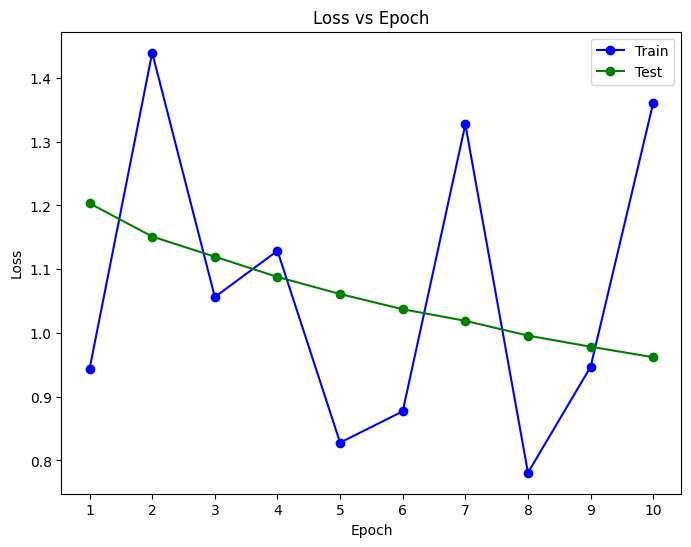

In [41]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [42]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.006222,0.0,0.426284,0.000000,0.596272,1.000000,0.011152,0.0
2,0.000000,0.0,0.003327,0.007481,0.999509,0.998528,0.000000,0.0
3,0.000000,0.0,0.045956,0.073150,0.994849,0.994112,0.000000,0.0
4,0.000000,0.0,0.148472,0.248545,0.987123,0.985280,0.000000,0.0
5,0.000000,0.0,0.309420,0.347465,0.971916,0.979392,0.000000,0.0
6,0.000000,0.0,0.388646,0.448878,0.960878,0.965653,0.000000,0.0
7,0.000000,0.0,0.464546,0.487947,0.947756,0.959764,0.000000,0.0
8,0.000000,0.0,0.510501,0.537822,0.938926,0.946516,0.000000,0.0
9,0.000346,0.0,0.538158,0.581047,0.931322,0.937684,0.000000,0.0


### Precision

In [43]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.125874,0.0,0.300984,0.000000,0.496173,0.481455,0.067039,0.0
2,0.000000,0.0,0.410256,0.450000,0.482448,0.483029,0.000000,0.0
3,0.000000,0.0,0.580052,0.564103,0.490121,0.496934,0.000000,0.0
4,0.000000,0.0,0.617647,0.667411,0.510205,0.530515,0.000000,0.0
5,0.000000,0.0,0.630776,0.675283,0.543814,0.552297,0.000000,0.0
6,0.000000,0.0,0.624040,0.651387,0.562173,0.578143,0.000000,0.0
7,0.000000,0.0,0.613399,0.633909,0.581490,0.591473,0.000000,0.0
8,0.000000,0.0,0.604978,0.615019,0.594687,0.606413,0.000000,0.0
9,1.000000,0.0,0.599768,0.611549,0.601934,0.618447,0.000000,0.0


### Recall

In [44]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.006222,0.0,0.426284,0.000000,0.596272,1.000000,0.011152,0.0
2,0.000000,0.0,0.003327,0.007481,0.999509,0.998528,0.000000,0.0
3,0.000000,0.0,0.045956,0.073150,0.994849,0.994112,0.000000,0.0
4,0.000000,0.0,0.148472,0.248545,0.987123,0.985280,0.000000,0.0
5,0.000000,0.0,0.309420,0.347465,0.971916,0.979392,0.000000,0.0
6,0.000000,0.0,0.388646,0.448878,0.960878,0.965653,0.000000,0.0
7,0.000000,0.0,0.464546,0.487947,0.947756,0.959764,0.000000,0.0
8,0.000000,0.0,0.510501,0.537822,0.938926,0.946516,0.000000,0.0
9,0.000346,0.0,0.538158,0.581047,0.931322,0.937684,0.000000,0.0


### F1-Score

In [45]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.011858,0.0,0.352840,0.000000,0.541636,0.649976,0.019124,0.0
2,0.000000,0.0,0.006601,0.014718,0.650777,0.651096,0.000000,0.0
3,0.000000,0.0,0.085164,0.129507,0.656709,0.662633,0.000000,0.0
4,0.000000,0.0,0.239396,0.362205,0.672712,0.689679,0.000000,0.0
5,0.000000,0.0,0.415179,0.458836,0.697408,0.706299,0.000000,0.0
6,0.000000,0.0,0.478985,0.531496,0.709339,0.723264,0.000000,0.0
7,0.000000,0.0,0.528695,0.551433,0.720761,0.731899,0.000000,0.0
8,0.000000,0.0,0.553739,0.573836,0.728172,0.739222,0.000000,0.0
9,0.000691,0.0,0.567295,0.595908,0.731247,0.745320,0.000000,0.0


### Gráfico ROC para cada clase

/tmp/ipykernel_33546/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


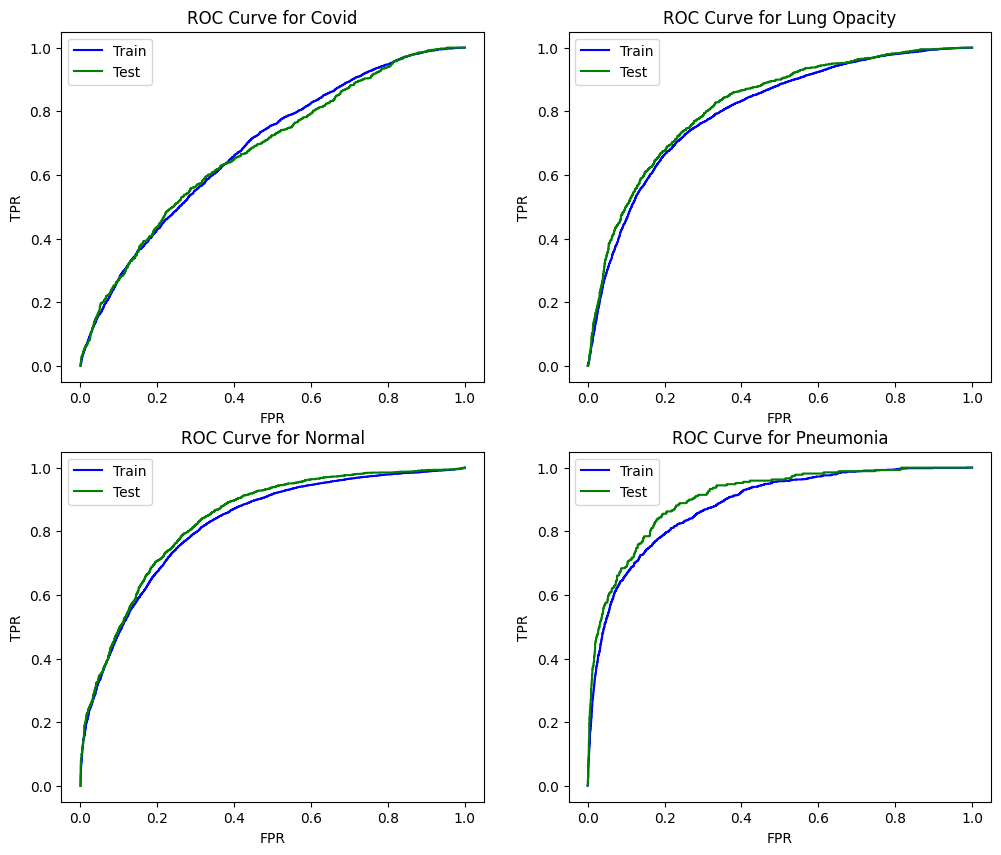

In [46]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Red Convolucional 
## Con Bilateral Filter

## Feature Engineering

In [47]:
bilateral_filtered_train_dataset = CustomDataset(bilateral_filtered_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

bilateral_filtered_test_dataset = CustomDataset(bilateral_filtered_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

## Entrenamiento del modelo

In [48]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 10

bilateral_filtered_cnn_model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(bilateral_filtered_cnn_model.parameters(), lr=learning_rate, momentum=momentum)

bilateral_filtered_train_dataloader = DataLoader(
    bilateral_filtered_train_dataset, batch_size=batch_size, shuffle=True)

bilateral_filtered_test_dataloader = DataLoader(
    bilateral_filtered_test_dataset, batch_size=batch_size, shuffle=True)

In [49]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(bilateral_filtered_train_dataloader, bilateral_filtered_cnn_model, loss_fn, optimizer)
    test_loss = test(bilateral_filtered_test_dataloader, bilateral_filtered_cnn_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.381668  [   32/16932]
Current Loss: 1.386536  [  352/16932]
Current Loss: 1.388241  [  672/16932]
Current Loss: 1.376634  [  992/16932]
Current Loss: 1.390175  [ 1312/16932]
Current Loss: 1.390407  [ 1632/16932]
Current Loss: 1.372564  [ 1952/16932]
Current Loss: 1.375779  [ 2272/16932]
Current Loss: 1.369886  [ 2592/16932]
Current Loss: 1.377564  [ 2912/16932]
Current Loss: 1.369727  [ 3232/16932]
Current Loss: 1.373278  [ 3552/16932]
Current Loss: 1.368793  [ 3872/16932]
Current Loss: 1.368340  [ 4192/16932]
Current Loss: 1.363760  [ 4512/16932]
Current Loss: 1.338536  [ 4832/16932]
Current Loss: 1.360788  [ 5152/16932]
Current Loss: 1.331620  [ 5472/16932]
Current Loss: 1.362805  [ 5792/16932]
Current Loss: 1.345374  [ 6112/16932]
Current Loss: 1.354767  [ 6432/16932]
Current Loss: 1.363764  [ 6752/16932]
Current Loss: 1.334198  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.006916,0.078969,0.961236,0.05948


--------------------------- Epoch 2 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.318943  [   32/16932]
Current Loss: 1.376809  [  352/16932]
Current Loss: 1.284063  [  672/16932]
Current Loss: 1.331931  [  992/16932]
Current Loss: 1.325455  [ 1312/16932]
Current Loss: 1.342751  [ 1632/16932]
Current Loss: 1.314492  [ 1952/16932]
Current Loss: 1.249406  [ 2272/16932]
Current Loss: 1.295637  [ 2592/16932]
Current Loss: 1.298393  [ 2912/16932]
Current Loss: 1.249149  [ 3232/16932]
Current Loss: 1.367955  [ 3552/16932]
Current Loss: 1.284780  [ 3872/16932]
Current Loss: 1.294086  [ 4192/16932]
Current Loss: 1.245192  [ 4512/16932]
Current Loss: 1.272193  [ 4832/16932]
Current Loss: 1.268642  [ 5152/16932]
Current Loss: 1.298010  [ 5472/16932]
Current Loss: 1.229525  [ 5792/16932]
Current Loss: 1.235488  [ 6112/16932]
Current Loss: 1.314435  [ 6432/16932]
Current Loss: 1.280814  [ 6752/16932]
Current Loss: 1.297315  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.15877,0.963199,0.02974


--------------------------- Epoch 3 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.261860  [   32/16932]
Current Loss: 1.164037  [  352/16932]
Current Loss: 1.217497  [  672/16932]
Current Loss: 1.237675  [  992/16932]
Current Loss: 1.149771  [ 1312/16932]
Current Loss: 1.093387  [ 1632/16932]
Current Loss: 1.061179  [ 1952/16932]
Current Loss: 1.127624  [ 2272/16932]
Current Loss: 1.270162  [ 2592/16932]
Current Loss: 1.213581  [ 2912/16932]
Current Loss: 1.159025  [ 3232/16932]
Current Loss: 1.219333  [ 3552/16932]
Current Loss: 1.240645  [ 3872/16932]
Current Loss: 1.233016  [ 4192/16932]
Current Loss: 1.251027  [ 4512/16932]
Current Loss: 1.240824  [ 4832/16932]
Current Loss: 1.278249  [ 5152/16932]
Current Loss: 1.112846  [ 5472/16932]
Current Loss: 1.269396  [ 5792/16932]
Current Loss: 1.224090  [ 6112/16932]
Current Loss: 1.206080  [ 6432/16932]
Current Loss: 1.369735  [ 6752/16932]
Current Loss: 1.319640  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.268495,0.94897,0.018587


--------------------------- Epoch 4 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.245367  [   32/16932]
Current Loss: 1.103455  [  352/16932]
Current Loss: 1.161513  [  672/16932]
Current Loss: 1.226812  [  992/16932]
Current Loss: 1.152903  [ 1312/16932]
Current Loss: 1.164700  [ 1632/16932]
Current Loss: 1.130695  [ 1952/16932]
Current Loss: 1.146625  [ 2272/16932]
Current Loss: 1.101449  [ 2592/16932]
Current Loss: 1.196984  [ 2912/16932]
Current Loss: 1.164615  [ 3232/16932]
Current Loss: 1.113377  [ 3552/16932]
Current Loss: 1.226364  [ 3872/16932]
Current Loss: 1.250115  [ 4192/16932]
Current Loss: 1.194863  [ 4512/16932]
Current Loss: 1.161662  [ 4832/16932]
Current Loss: 1.194078  [ 5152/16932]
Current Loss: 1.208311  [ 5472/16932]
Current Loss: 1.165349  [ 5792/16932]
Current Loss: 1.092887  [ 6112/16932]
Current Loss: 1.170621  [ 6432/16932]
Current Loss: 1.214702  [ 6752/16932]
Current Loss: 1.088231  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.359933,0.930815,0.02974


--------------------------- Epoch 5 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.249178  [   32/16932]
Current Loss: 1.087490  [  352/16932]
Current Loss: 1.085069  [  672/16932]
Current Loss: 1.153622  [  992/16932]
Current Loss: 1.066014  [ 1312/16932]
Current Loss: 1.283682  [ 1632/16932]
Current Loss: 1.115721  [ 1952/16932]
Current Loss: 1.262927  [ 2272/16932]
Current Loss: 1.181473  [ 2592/16932]
Current Loss: 1.338125  [ 2912/16932]
Current Loss: 1.022415  [ 3232/16932]
Current Loss: 1.171483  [ 3552/16932]
Current Loss: 1.138788  [ 3872/16932]
Current Loss: 1.174677  [ 4192/16932]
Current Loss: 1.032759  [ 4512/16932]
Current Loss: 1.241982  [ 4832/16932]
Current Loss: 1.034897  [ 5152/16932]
Current Loss: 1.218426  [ 5472/16932]
Current Loss: 1.142162  [ 5792/16932]
Current Loss: 1.065476  [ 6112/16932]
Current Loss: 1.024951  [ 6432/16932]
Current Loss: 1.089107  [ 6752/16932]
Current Loss: 0.947351  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.42394,0.910697,0.04461


--------------------------- Epoch 6 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.178977  [   32/16932]
Current Loss: 1.021665  [  352/16932]
Current Loss: 1.126161  [  672/16932]
Current Loss: 1.133425  [  992/16932]
Current Loss: 1.205495  [ 1312/16932]
Current Loss: 1.220976  [ 1632/16932]
Current Loss: 1.200006  [ 1952/16932]
Current Loss: 0.969843  [ 2272/16932]
Current Loss: 1.109388  [ 2592/16932]
Current Loss: 0.991422  [ 2912/16932]
Current Loss: 1.111026  [ 3232/16932]
Current Loss: 1.188182  [ 3552/16932]
Current Loss: 0.953157  [ 3872/16932]
Current Loss: 1.022444  [ 4192/16932]
Current Loss: 0.993824  [ 4512/16932]
Current Loss: 1.088899  [ 4832/16932]
Current Loss: 1.048878  [ 5152/16932]
Current Loss: 1.054873  [ 5472/16932]
Current Loss: 1.047773  [ 5792/16932]
Current Loss: 1.028273  [ 6112/16932]
Current Loss: 1.207783  [ 6432/16932]
Current Loss: 1.103426  [ 6752/16932]
Current Loss: 1.008361  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.453034,0.903337,0.052045


--------------------------- Epoch 7 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.063203  [   32/16932]
Current Loss: 1.203671  [  352/16932]
Current Loss: 1.038548  [  672/16932]
Current Loss: 1.192547  [  992/16932]
Current Loss: 1.149769  [ 1312/16932]
Current Loss: 1.121420  [ 1632/16932]
Current Loss: 1.062121  [ 1952/16932]
Current Loss: 1.118053  [ 2272/16932]
Current Loss: 1.127997  [ 2592/16932]
Current Loss: 1.007852  [ 2912/16932]
Current Loss: 1.171699  [ 3232/16932]
Current Loss: 1.061824  [ 3552/16932]
Current Loss: 1.048965  [ 3872/16932]
Current Loss: 1.014892  [ 4192/16932]
Current Loss: 1.002706  [ 4512/16932]
Current Loss: 0.984175  [ 4832/16932]
Current Loss: 0.966475  [ 5152/16932]
Current Loss: 1.040279  [ 5472/16932]
Current Loss: 1.152933  [ 5792/16932]
Current Loss: 1.219459  [ 6112/16932]
Current Loss: 1.150100  [ 6432/16932]
Current Loss: 1.092894  [ 6752/16932]
Current Loss: 1.115239  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.489609,0.896467,0.074349


--------------------------- Epoch 8 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.082917  [   32/16932]
Current Loss: 1.071179  [  352/16932]
Current Loss: 1.060610  [  672/16932]
Current Loss: 1.123063  [  992/16932]
Current Loss: 1.164338  [ 1312/16932]
Current Loss: 1.151439  [ 1632/16932]
Current Loss: 1.176854  [ 1952/16932]
Current Loss: 1.214299  [ 2272/16932]
Current Loss: 1.407264  [ 2592/16932]
Current Loss: 0.969983  [ 2912/16932]
Current Loss: 0.953589  [ 3232/16932]
Current Loss: 0.990703  [ 3552/16932]
Current Loss: 1.132428  [ 3872/16932]
Current Loss: 1.017175  [ 4192/16932]
Current Loss: 1.032223  [ 4512/16932]
Current Loss: 0.919370  [ 4832/16932]
Current Loss: 0.885191  [ 5152/16932]
Current Loss: 0.929718  [ 5472/16932]
Current Loss: 1.218607  [ 5792/16932]
Current Loss: 0.956001  [ 6112/16932]
Current Loss: 1.026025  [ 6432/16932]
Current Loss: 1.237831  [ 6752/16932]
Current Loss: 0.978493  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.509559,0.892051,0.111524


--------------------------- Epoch 9 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.129322  [   32/16932]
Current Loss: 1.203454  [  352/16932]
Current Loss: 1.014982  [  672/16932]
Current Loss: 0.917822  [  992/16932]
Current Loss: 0.935832  [ 1312/16932]
Current Loss: 1.105428  [ 1632/16932]
Current Loss: 1.214373  [ 1952/16932]
Current Loss: 1.022220  [ 2272/16932]
Current Loss: 1.127065  [ 2592/16932]
Current Loss: 1.007265  [ 2912/16932]
Current Loss: 1.130857  [ 3232/16932]
Current Loss: 1.125025  [ 3552/16932]
Current Loss: 1.043748  [ 3872/16932]
Current Loss: 0.968008  [ 4192/16932]
Current Loss: 1.212416  [ 4512/16932]
Current Loss: 1.081436  [ 4832/16932]
Current Loss: 1.169297  [ 5152/16932]
Current Loss: 1.130922  [ 5472/16932]
Current Loss: 0.991236  [ 5792/16932]
Current Loss: 1.069914  [ 6112/16932]
Current Loss: 1.111763  [ 6432/16932]
Current Loss: 1.165385  [ 6752/16932]
Current Loss: 1.057597  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.523691,0.888616,0.156134


--------------------------- Epoch 10 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.187039  [   32/16932]
Current Loss: 1.065232  [  352/16932]
Current Loss: 0.900111  [  672/16932]
Current Loss: 1.142459  [  992/16932]
Current Loss: 0.884121  [ 1312/16932]
Current Loss: 1.069637  [ 1632/16932]
Current Loss: 1.198925  [ 1952/16932]
Current Loss: 1.031356  [ 2272/16932]
Current Loss: 0.901983  [ 2592/16932]
Current Loss: 1.128631  [ 2912/16932]
Current Loss: 0.978755  [ 3232/16932]
Current Loss: 1.078015  [ 3552/16932]
Current Loss: 0.970831  [ 3872/16932]
Current Loss: 1.014430  [ 4192/16932]
Current Loss: 1.215374  [ 4512/16932]
Current Loss: 1.035578  [ 4832/16932]
Current Loss: 1.136135  [ 5152/16932]
Current Loss: 1.120227  [ 5472/16932]
Current Loss: 1.270219  [ 5792/16932]
Current Loss: 1.325773  [ 6112/16932]
Current Loss: 1.122416  [ 6432/16932]
Current Loss: 0.949514  [ 6752/16932]
Current Loss: 1.053159  [ 7072/16

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.0,0.533666,0.887635,0.230483


Training time: 33.826 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_33546/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


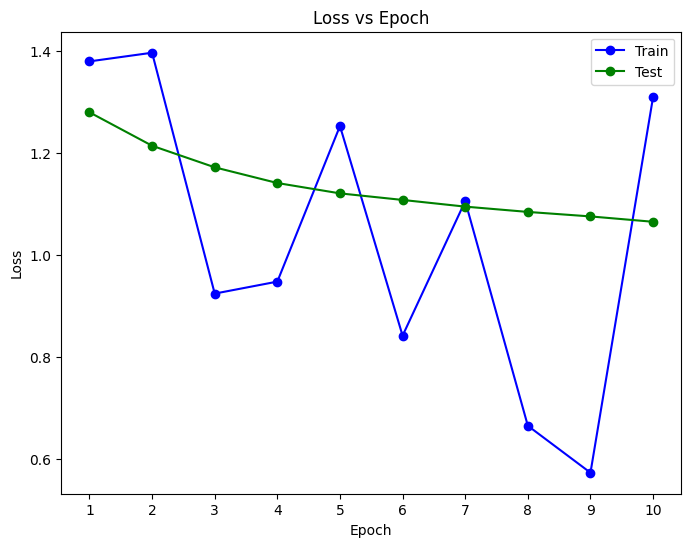

In [50]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [51]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.144141,0.006916,0.159493,0.078969,0.744420,0.961236,0.158922,0.059480
2,0.006568,0.000000,0.112913,0.158770,0.952293,0.963199,0.041822,0.029740
3,0.003111,0.000000,0.196714,0.268495,0.945180,0.948970,0.026022,0.018587
4,0.002074,0.000000,0.302766,0.359933,0.926784,0.930815,0.026952,0.029740
5,0.000346,0.000000,0.369515,0.423940,0.913417,0.910697,0.030669,0.044610
6,0.001037,0.000000,0.429611,0.453034,0.898209,0.903337,0.049257,0.052045
7,0.000691,0.000000,0.456228,0.489609,0.886436,0.896467,0.073420,0.074349
8,0.000346,0.000000,0.478894,0.509559,0.880549,0.892051,0.115242,0.111524
9,0.001383,0.000000,0.489707,0.523691,0.877729,0.888616,0.156134,0.156134


### Precision

In [52]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.206028,0.192308,0.357076,0.384615,0.512582,0.497587,0.186275,0.695652
2,0.260274,0.000000,0.405527,0.509333,0.502882,0.510799,0.569620,0.727273
3,0.428571,0.000000,0.455684,0.534768,0.521201,0.534254,0.583333,0.625000
4,0.461538,0.000000,0.487936,0.534568,0.544178,0.556142,0.604167,0.666667
5,0.333333,0.000000,0.500846,0.529046,0.558907,0.571077,0.600000,0.631579
6,0.500000,0.000000,0.505505,0.530672,0.574026,0.578385,0.662500,0.608696
7,0.500000,0.000000,0.508813,0.533998,0.578009,0.589545,0.711712,0.645161
8,0.333333,0.000000,0.512119,0.543440,0.585167,0.593536,0.765432,0.714286
9,0.571429,0.000000,0.522521,0.551664,0.587121,0.597099,0.736842,0.724138


### Recall

In [53]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.144141,0.006916,0.159493,0.078969,0.744420,0.961236,0.158922,0.059480
2,0.006568,0.000000,0.112913,0.158770,0.952293,0.963199,0.041822,0.029740
3,0.003111,0.000000,0.196714,0.268495,0.945180,0.948970,0.026022,0.018587
4,0.002074,0.000000,0.302766,0.359933,0.926784,0.930815,0.026952,0.029740
5,0.000346,0.000000,0.369515,0.423940,0.913417,0.910697,0.030669,0.044610
6,0.001037,0.000000,0.429611,0.453034,0.898209,0.903337,0.049257,0.052045
7,0.000691,0.000000,0.456228,0.489609,0.886436,0.896467,0.073420,0.074349
8,0.000346,0.000000,0.478894,0.509559,0.880549,0.892051,0.115242,0.111524
9,0.001383,0.000000,0.489707,0.523691,0.877729,0.888616,0.156134,0.156134


### F1-Score

In [54]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.169616,0.013351,0.220497,0.131034,0.607121,0.655732,0.171515,0.109589
2,0.012812,0.000000,0.176643,0.242079,0.658190,0.667574,0.077922,0.057143
3,0.006177,0.000000,0.274800,0.357499,0.671897,0.683634,0.049822,0.036101
4,0.004129,0.000000,0.373669,0.430204,0.685722,0.696275,0.051601,0.056940
5,0.000691,0.000000,0.425272,0.470697,0.693482,0.701967,0.058355,0.083333
6,0.002070,0.000000,0.464478,0.488789,0.700426,0.705229,0.091696,0.095890
7,0.001381,0.000000,0.481088,0.510841,0.699743,0.711310,0.133109,0.133333
8,0.000691,0.000000,0.494949,0.525955,0.703094,0.712801,0.200323,0.192926
9,0.002759,0.000000,0.505582,0.537313,0.703598,0.714258,0.257669,0.256881


### Gráfico ROC para cada clase

/tmp/ipykernel_33546/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


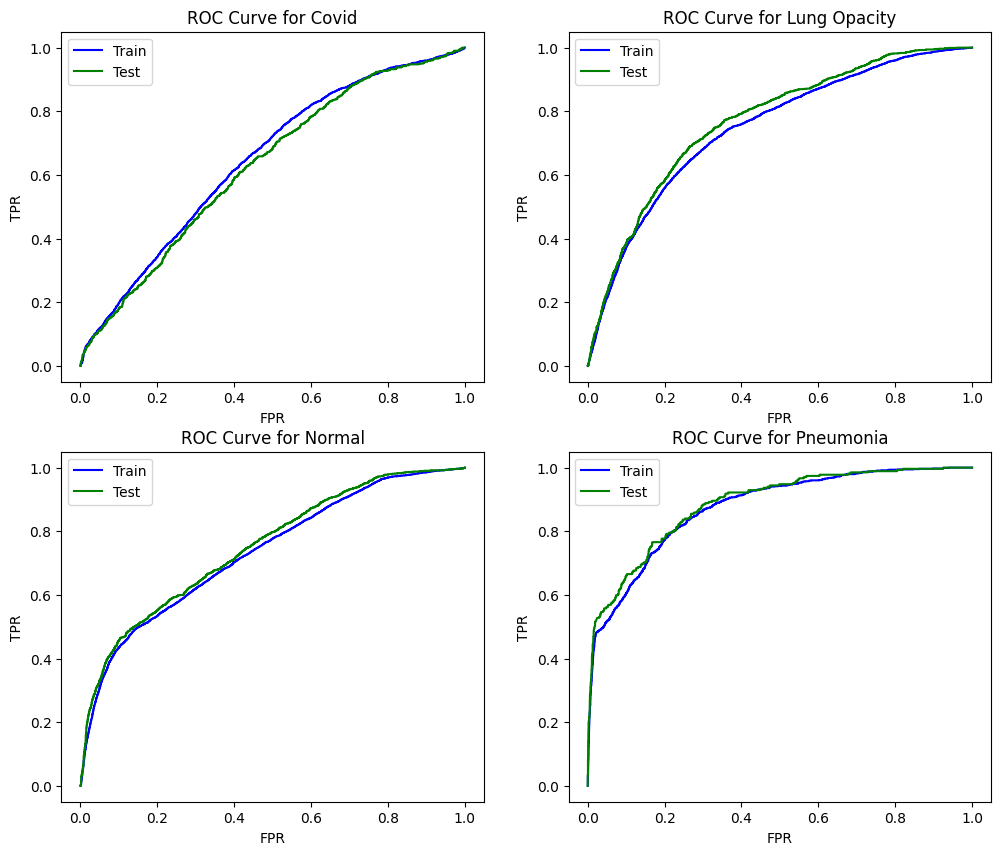

In [55]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Saliency Maps

In [1]:
unfiltered_cnn_model.eval()

X_test = next(iter(unfiltered_test_dataloader))

num_samples = 4

fig, ax = plt.subplots(2, num_samples, figsize=(16, 8))

for i in range(num_samples):
    current_sample = X_test[0][i]
    
    current_sample.requires_grad_()

    scores = unfiltered_cnn_model(current_sample)

    score_max_index = scores[0].argmax()
    score_max = scores[0, score_max_index.item()]

    score_max.backward()

    X_test_grad = current_sample.grad.abs()

    X_test_grad = X_test_grad.detach().numpy()

    ax[0, i].imshow(current_sample[0].detach().numpy())
    ax[0, i].axis('off')

    img = ax[1, i].imshow(X_test_grad[0], cmap=plt.cm.hot)
    ax[1, i].axis('off')

plt.show()

NameError: name 'unfiltered_cnn_model' is not defined